In [ ]:
import pandas as pd
from tqdm import tqdm_notebook

# 주식데이터 불러오기

In [ ]:
def stock_data(fname):
    stock = pd.read_excel(fname)
    
    
    stock.dropna(axis=0, how ='any', inplace=True) # 시장 문 닫은 주말 제거
    
    company_name = list(set(stock.회사이름)) # 회사이름 획득.
    
    stock_anal = stock[['날짜','종가','회사이름','업종']] # 필요한 변수
    stock_date = [i.replace('.','') for i in stock_anal['날짜'].tolist()] # 날짜 변수 전처리
    
    stock_anal['날짜'] = stock_date
    
    stock_anal.reset_index(drop=True, inplace=True)
    
    return stock_anal

In [ ]:
stock_anal = stock_data('주식 시세_최종.xlsx') # 주식 데이터 불러오기. 실행.

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
stock_anal.head() # 불러온 결과.

,날짜,종가,회사이름,업종
0,20200612,52300.0,삼성전자,반도체와반도체장비
1,20200611,54300.0,삼성전자,반도체와반도체장비
2,20200610,55400.0,삼성전자,반도체와반도체장비
3,20200609,55500.0,삼성전자,반도체와반도체장비
4,20200608,54900.0,삼성전자,반도체와반도체장비


# 코로나 데이터 불러오기

In [ ]:
def corona_data(fname):
    corona=pd.read_csv(fname, encoding='cp949')
    
    corona = pd.pivot_table(data=corona, index='date', columns='region',values='confirmed') #피벗테이블
    
    corona["확진자"]=corona.sum(axis=1) # 전국 확진자 합계
    
    # 필요한 변수
    corona=corona[['확진자']]
    corona['날짜'] = [str(i) for i in corona.index]
    
    return corona

In [ ]:
corona = corona_data('코로나 발생.txt') # 코로나 데이터 불러오기. 실행.

In [ ]:
corona.head() #불러온 결과

region,확진자,날짜
date,,
20200217,30,20200217
20200218,31,20200218
20200219,51,20200219
20200220,108,20200220
20200221,205,20200221


# 코로나+주식 데이터 병합

In [ ]:
def combine(corona, stock):
    stock_corona = pd.merge(left=stock, right=corona, on='날짜') # 병합
    
    stock_corona.sort_values(by=['회사이름','날짜'],ascending=True, inplace=True) # 정렬
    
    return stock_corona

In [ ]:
stock_corona = combine(corona, stock_anal) # 데이터 병합하기.

In [ ]:
stock_corona.head() # 실행결과.

,날짜,종가,회사이름,업종,확진자
125040,20200217,4920.0,AJ네트웍스,도로와철도운송,30
123494,20200218,4965.0,AJ네트웍스,도로와철도운송,31
121948,20200219,4905.0,AJ네트웍스,도로와철도운송,51
120402,20200220,4855.0,AJ네트웍스,도로와철도운송,108
118856,20200221,4840.0,AJ네트웍스,도로와철도운송,205


# 상관계수

In [ ]:
company_name=list(set(stock_corona['회사이름'].tolist())) # 회사이름 명단.

def correlation(data):
    n=[]
    c=[]
    for i in tqdm_notebook(company_name[:]):
        tmp = data[data['회사이름'].apply(lambda x: x==i)].reset_index(drop=True)
        c.append(tmp[['확진자','종가']].corr().iloc[1,0])
        n.append(i)
        
    result = pd.DataFrame([n,c]).T
    
    result.columns = ['회사이름','상관계수']
    
    result = result.sort_values(by=['상관계수'], ascending=False).reset_index(drop=True)
    
    return result

In [ ]:
result=correlation(stock_corona)# 실행결과

In [ ]:
result_domain=pd.merge(left=result, right=stock_corona[['회사이름','업종']].drop_duplicates(), on='회사이름')

#### <span style='background:orange'>  '회사이름', '업종', '상관계수' 엑셀 파일 저장

In [ ]:
result_domain.to_excel('주식_코로나_상관계수.xlsx')

# 코로나 확진자 현황 그래프

In [ ]:
# 한글깨짐을 위한 기본세팅
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

plt.rcParams['figure.figsize'] = (15,7)

#### 누적 확진자 그래프 

Text(115, -1000, '6월 15일')

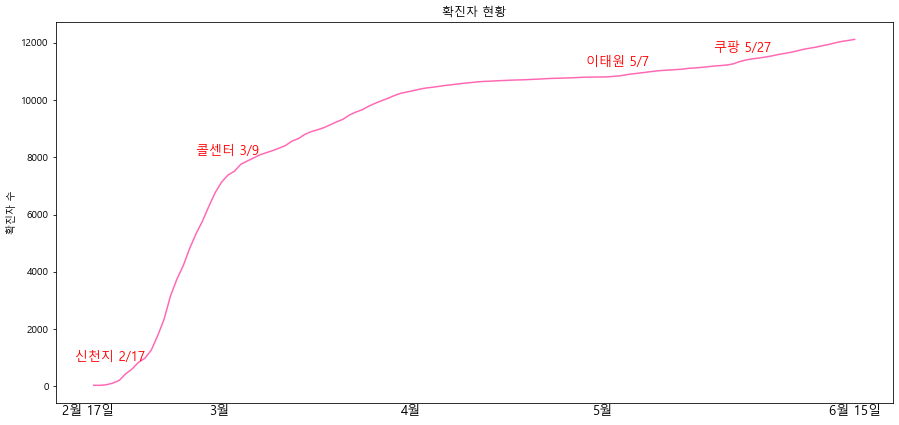

In [ ]:
plt.plot(range(len(corona)), corona.확진자, color='hotpink')
plt.title('확진자 현황', ) # 제목 붙이기
plt.ylabel('확진자 수')

frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)

plt.text(-3,900,'신천지 2/17', fontsize=13, color='r')
plt.text(-5,-1000,'2월 17일', fontsize=13)
plt.text(18,-1000,'3월', fontsize=13)
plt.text(48,-1000,'4월', fontsize=13)
plt.text(78,-1000,'5월', fontsize=13)
plt.text(16,8100,'콜센터 3/9', fontsize=13, color='r')
plt.text(77,11200,'이태원 5/7', fontsize=13, color='r')
plt.text(97,11700,'쿠팡 5/27', fontsize=13, color='r')
plt.text(115,-1000,'6월 15일', fontsize=13)



# 상관관계가 있는 회사들 살펴보기

In [ ]:
domain = list(set(result_domain.업종)) # 업종 리스트.

In [ ]:
# 업종이 없거나, 상장폐지된 회사 제외.
import math
pre = result_domain[result_domain['업종'].apply(lambda x: x != '없종없음')] # 업종없는 회사 제외
pre = pre[pre['상관계수'].apply(lambda k: math.isnan(k) == False)].reset_index(drop=True)# 거래정지된 회사 제외

 #### <span style='background:orange'> 상관계수 0.4를 기준으로 양/음의 상관관계가 있음을 기준으로 함

In [ ]:
positive = pre[pre['상관계수'].apply(lambda x: x >= 0.4)]
negative = pre[pre['상관계수'].apply(lambda x: x <= -0.4)]

### 양의 상관관계가 있는 회사

Text(0.5, 0, '업종')

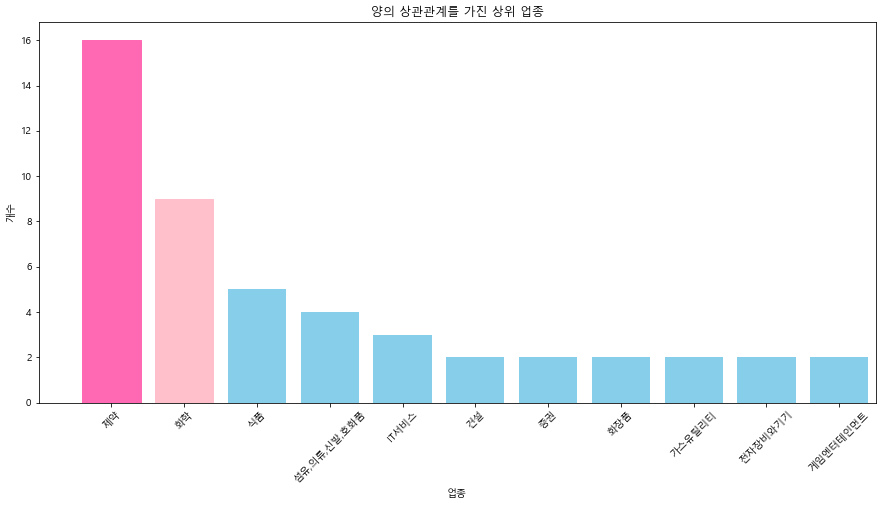

In [ ]:
from collections import Counter

tmp=pd.DataFrame([dict(Counter(positive.업종)).keys(), dict(Counter(positive.업종)).values()]).T
tmp.columns=['업종','개수']
tmp.sort_values(by='개수', ascending=False, inplace=True)
tmp.reset_index(drop=True, inplace=True)

bar=plt.bar(tmp.업종, tmp.개수, color='skyblue')
bar[0].set_color('hotpink')
bar[1].set_color('pink')

plt.xticks(rotation=45)
plt.xlim(-1,10.5)

plt.title('양의 상관관계를 가진 상위 업종')
plt.ylabel('개수')
plt.xlabel('업종')

#### <span style='background:yellow'> 양의 상관관계를 가진 제약회사

In [ ]:
tmp = pre[pre['업종'].apply(lambda x: x=='제약')]
tmp[tmp['상관계수']>=0.4]

,회사이름,상관계수,업종
2,부광약품,0.813778,제약
7,녹십자,0.755467,제약
8,신풍제약,0.747607,제약
10,신풍제약우,0.711117,제약
19,셀트리온,0.627518,제약
25,일양약품,0.589825,제약
26,녹십자홀딩스,0.584558,제약
33,삼성바이오로직스,0.529724,제약
34,JW중외제약,0.521294,제약
36,동화약품,0.516215,제약


In [ ]:
tmp = pre[pre['업종'].apply(lambda x: x=='제약')]
tmp

,회사이름,상관계수,업종
2,부광약품,0.813778,제약
7,녹십자,0.755467,제약
8,신풍제약,0.747607,제약
10,신풍제약우,0.711117,제약
19,셀트리온,0.627518,제약
25,일양약품,0.589825,제약
26,녹십자홀딩스,0.584558,제약
33,삼성바이오로직스,0.529724,제약
34,JW중외제약,0.521294,제약
36,동화약품,0.516215,제약


#### <span style='background:yellow'> 양의 상관관계를 가진 화학회사

In [ ]:
tmp = pre[pre['업종'].apply(lambda x: x=='화학')]
tmp[tmp['상관계수']>=0.4]

,회사이름,상관계수,업종
1,파미셀,0.820334,화학
13,미원에스씨,0.693412,화학
14,동남합성,0.687544,화학
15,SK케미칼,0.686482,화학
35,미원상사,0.518877,화학
40,대한유화,0.503017,화학
57,미원홀딩스,0.446974,화학
65,경농,0.414391,화학
66,SK케미칼우,0.414033,화학


### 양의 상관관계가 가장 높은 제약회사들과 확진자수 그래프

In [ ]:
p1=stock_anal[stock_anal['회사이름']=='부광약품'].sort_values(by='날짜',ascending=True)
p2=stock_anal[stock_anal['회사이름']=='녹십자'].sort_values(by='날짜',ascending=True)
p3=stock_anal[stock_anal['회사이름']=='신풍제약'].sort_values(by='날짜',ascending=True)
p4=stock_anal[stock_anal['회사이름']=='셀트리온'].sort_values(by='날짜',ascending=True)
p5=stock_anal[stock_anal['회사이름']=='일양약품'].sort_values(by='날짜',ascending=True)
k1=corona

In [ ]:
from sklearn import preprocessing
import numpy as np
def standard(data, column):
    x_array = np.array(data[column])
    stand = preprocessing.normalize([x_array])
    return stand[0]

p1['standard']=standard(p1,'종가')
p2['standard']=standard(p2,'종가')
p3['standard']=standard(p3,'종가')
p4['standard']=standard(p4,'종가')
p5['standard']=standard(p5,'종가')
k1['standard']=standard(k1,'확진자')


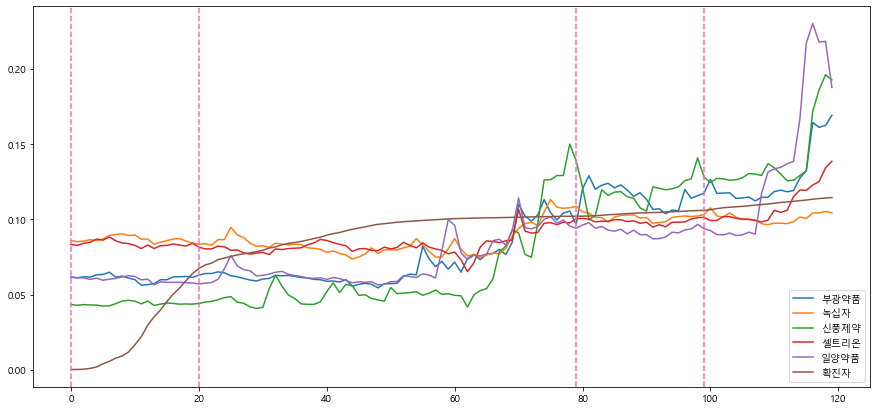

In [ ]:
plt.plot(range(120), p1.standard)
plt.plot(range(120), p2.standard)
plt.plot(range(120), p3.standard)
plt.plot(range(120), p4.standard)
plt.plot(range(120), p5.standard)
plt.plot(range(120), k1.standard)

plt.legend(['부광약품','녹십자','신풍제약','셀트리온','일양약품','확진자'])
plt.axvline(x=0, ymin=0, ymax=1, color='hotpink',linestyle='--')
plt.axvline(x=20, ymin=0, ymax=1, color='hotpink',linestyle='--')
plt.axvline(x=79, ymin=0, ymax=1, color='hotpink',linestyle='--')
plt.axvline(x=99, ymin=0, ymax=1, color='hotpink',linestyle='--')



### 음의 상관관계가 있는 회사

Text(0.5, 0, '업종')

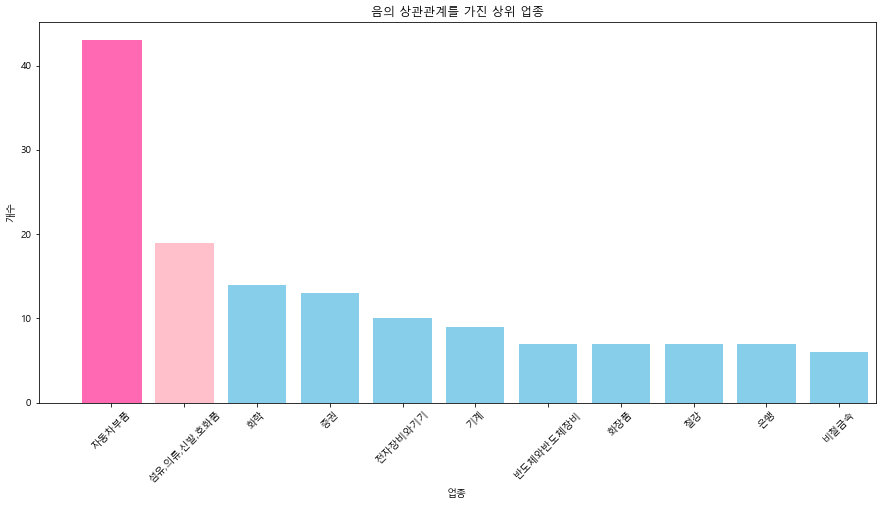

In [ ]:
from collections import Counter

tmp=pd.DataFrame([dict(Counter(negative.업종)).keys(), dict(Counter(negative.업종)).values()]).T
tmp.columns=['업종','개수']
tmp.sort_values(by='개수', ascending=False, inplace=True)
tmp.reset_index(drop=True, inplace=True)

bar=plt.bar(tmp.업종, tmp.개수, color='skyblue')
bar[0].set_color('hotpink')
bar[1].set_color('pink')

plt.xticks(rotation=45)
plt.xlim(-1,10.5)

plt.title('음의 상관관계를 가진 상위 업종')
plt.ylabel('개수')
plt.xlabel('업종')

#### <span style='background:yellow'> 음의 상관관계를 가진 자동차부품 회사

In [ ]:
tmp = pre[pre['업종'].apply(lambda x: x=='자동차부품')]
tmp[tmp['상관계수']<=-0.4]

,회사이름,상관계수,업종
646,태양금속,-0.418042,자동차부품
660,인지컨트롤스,-0.432898,자동차부품
661,SG충방,-0.433036,자동차부품
677,태양금속우,-0.448678,자동차부품
707,지엠비코리아,-0.485607,자동차부품
711,지코,-0.491705,자동차부품
717,넥센타이어,-0.506425,자동차부품
719,현대모비스,-0.507836,자동차부품
720,SJM,-0.507934,자동차부품
726,에스엘,-0.513953,자동차부품


#### <span style='background:yellow'> 음의 상관관계를 가진 섬유,의류,신발,호화품 회사

In [ ]:
tmp = pre[pre['업종'].apply(lambda x: x=='섬유,의류,신발,호화품')]
tmp[tmp['상관계수']<=-0.4]

,회사이름,상관계수,업종
637,삼양통상,-0.402865,"섬유,의류,신발,호화품"
647,일신방직,-0.419651,"섬유,의류,신발,호화품"
649,TBH글로벌,-0.420171,"섬유,의류,신발,호화품"
656,신영와코루,-0.425399,"섬유,의류,신발,호화품"
682,한세엠케이,-0.456292,"섬유,의류,신발,호화품"
686,SG세계물산,-0.45842,"섬유,의류,신발,호화품"
708,유니켐,-0.488342,"섬유,의류,신발,호화품"
733,백산,-0.526835,"섬유,의류,신발,호화품"
735,방림,-0.529063,"섬유,의류,신발,호화품"
746,효성티앤씨,-0.544205,"섬유,의류,신발,호화품"


### 음의 상관관계가 높은 자동차부품 회사와 확진자 그래프

In [ ]:
p1=stock_anal[stock_anal['회사이름']=='일정실업'].sort_values(by='날짜',ascending=True)
p2=stock_anal[stock_anal['회사이름']=='우신시스템'].sort_values(by='날짜',ascending=True)
p3=stock_anal[stock_anal['회사이름']=='금호타이어'].sort_values(by='날짜',ascending=True)
p4=stock_anal[stock_anal['회사이름']=='새론오토모티브'].sort_values(by='날짜',ascending=True)
p5=stock_anal[stock_anal['회사이름']=='상신브레이크'].sort_values(by='날짜',ascending=True)
k1=corona

In [ ]:
# from sklearn import preprocessing
import numpy as np
def standard(data, column):
    x_array = np.array(data[column])
    stand = preprocessing.normalize([x_array])
    return stand[0]

p1['standard']=standard(p1,'종가')
p2['standard']=standard(p2,'종가')
p3['standard']=standard(p3,'종가')
p4['standard']=standard(p4,'종가')
p5['standard']=standard(p5,'종가')
k1['standard']=standard(k1,'확진자')


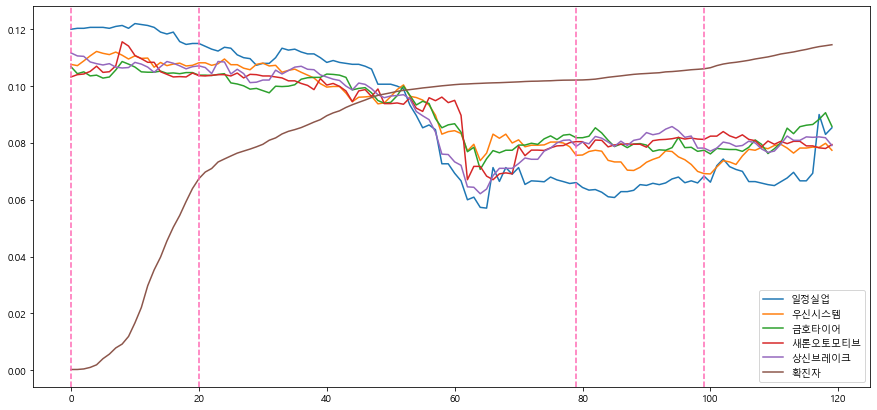

In [ ]:
plt.plot(range(120), p1.standard)
plt.plot(range(120), p2.standard)
plt.plot(range(120), p3.standard)
plt.plot(range(120), p4.standard)
plt.plot(range(120), p5.standard)
plt.plot(range(120), k1.standard)

plt.legend(['일정실업','우신시스템','금호타이어','새론오토모티브','상신브레이크','확진자'])
plt.axvline(x=0, ymin=0, ymax=1, color='hotpink',linestyle='--')
plt.axvline(x=20, ymin=0, ymax=1, color='hotpink',linestyle='--')
plt.axvline(x=79, ymin=0, ymax=1, color='hotpink',linestyle='--')
plt.axvline(x=99, ymin=0, ymax=1, color='hotpink',linestyle='--')



# issue day 구간 별로 확진자와 주가 비교

2월 17일 - 신천지
3월 9일 - 구로 콜센터
5월 7일 - 이태원 클럽
5월 27일 - 쿠팡 부천물류센터


#### 이슈 구간 나누기

In [ ]:

corona_specific = corona 
corona_specific['d'] = corona_specific.index

corona_daegu = corona_specific[corona_specific['d'] < 20200308]
corona_guro= corona_specific[corona_specific['d'].apply(lambda x: x>=20200309 and x<=20200329)]
corona_club= corona_specific[corona_specific['d'].apply(lambda x: x>=20200507 and x<=20200527)]
corona_coopang= corona_specific[corona_specific['d'].apply(lambda x: x>=20200527 and x<=20200616)]

In [ ]:
result_daegu=correlation(combine(corona_daegu, stock_anal))
result_guro=correlation(combine(corona_guro,stock_anal))
result_club=correlation(combine(corona_club,stock_anal))
result_coopang=correlation(combine(corona_coopang,stock_anal))

### 1. 대구 코로나 2월 17일 후 20 일 동안

In [ ]:
final_daegu=pd.merge(left=result_daegu, right=stock_corona[['회사이름','업종']].drop_duplicates(), on='회사이름') # stock data와 병합

final_daegu=final_daegu[final_daegu['업종']!='없종없음']

positive = final_daegu[final_daegu['상관계수'].apply(lambda x: x >= 0.4)]
negative = final_daegu[final_daegu['상관계수'].apply(lambda x: x <= -0.4)]

In [ ]:
def top_bar_graph(data,num=1):
    from collections import Counter

    tmp=pd.DataFrame([dict(Counter(data.업종)).keys(), dict(Counter(data.업종)).values()]).T
    tmp.columns=['업종','개수']
    tmp.sort_values(by='개수', ascending=False, inplace=True)
    tmp.reset_index(drop=True, inplace=True)

    bar=plt.bar(tmp.업종, tmp.개수, color='skyblue')
    bar[0].set_color('hotpink')
    bar[1].set_color('pink')

    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlim(-1,10.5)
    if num ==1:
        plt.title('양의 상관관계를 가진 상위 업종', fontsize= 20)
    else:
        plt.title('음의 상관관계를 가진 상위 업종', fontsize= 20)
    plt.ylabel('개수', fontsize=15)
    plt.xlabel('업종', fontsize=15)

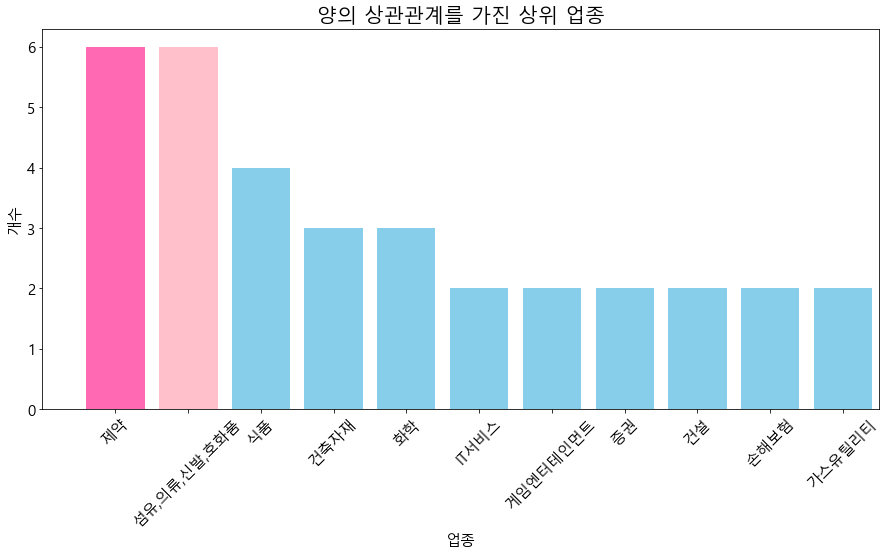

In [ ]:
top_bar_graph(positive,1)

처음에 제조회사가 종목이 꽤 존재한다. 아직 직격탄을 맞지 않은 상태.

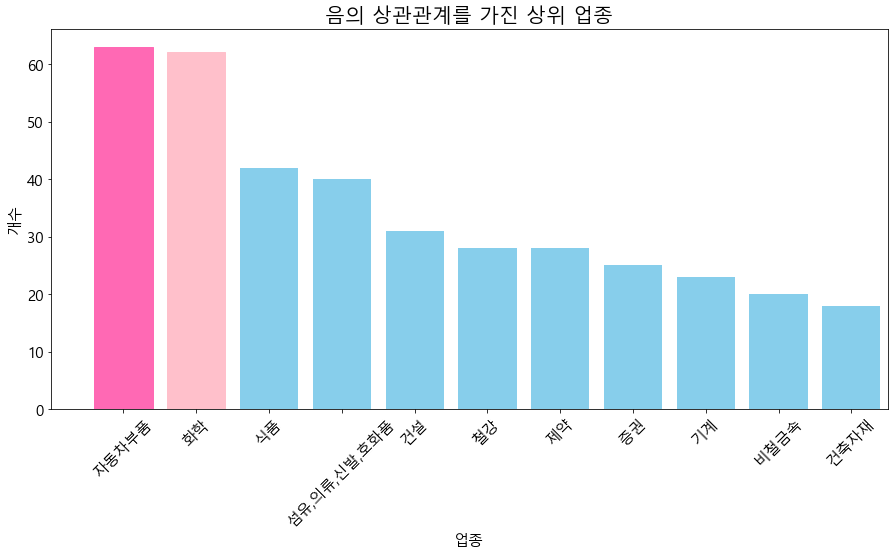

In [ ]:
top_bar_graph(negative,0)

빈도 자체는 음의 상관관계에서 훨씬 많이 존재한다.즉 확진자가 늘수록 주가가 떨어지는 기업이 훨씬 많다는 소리.


### 3월 9일 구로 콜센터 이후 20일간

In [ ]:
final_guro=pd.merge(left=result_guro, right=stock_corona[['회사이름','업종']].drop_duplicates(), on='회사이름') # stock data와 병합

final_guro=final_guro[final_guro['업종']!='없종없음']

positive = final_guro[final_guro['상관계수'].apply(lambda x: x >= 0.4)]
negative = final_guro[final_guro['상관계수'].apply(lambda x: x <= -0.4)]

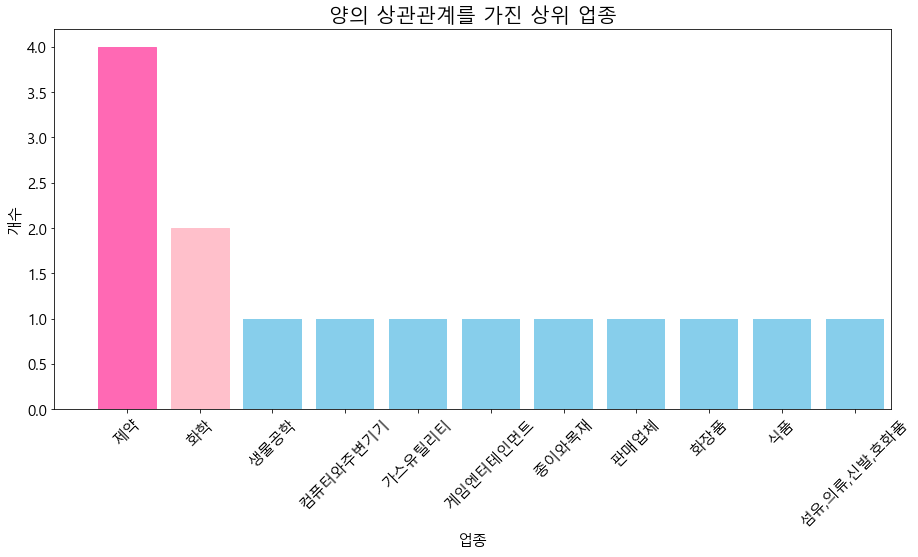

In [ ]:
top_bar_graph(positive,1)

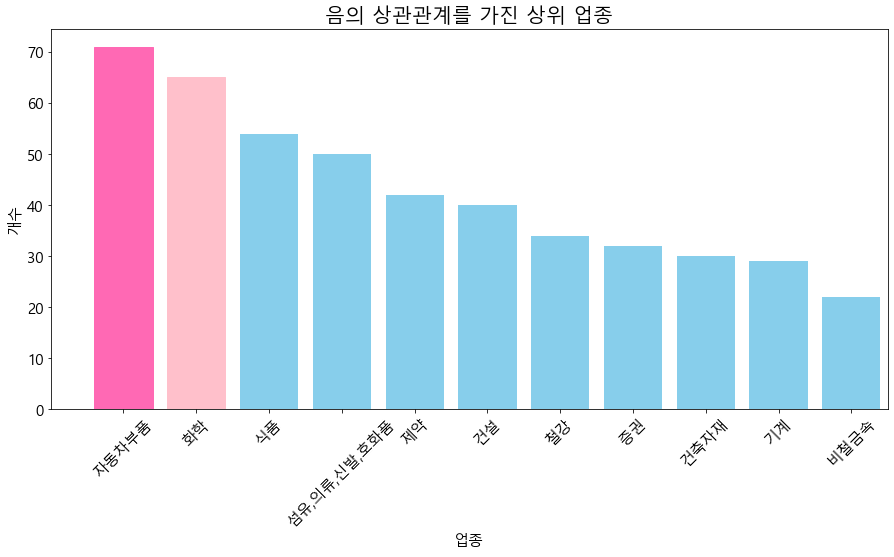

In [ ]:
top_bar_graph(negative,0)

### 3. 5월 7일 이태원 클럽 이후 20일 간

In [ ]:
final_club=pd.merge(left=result_club, right=stock_corona[['회사이름','업종']].drop_duplicates(), on='회사이름') # stock data와 병합

final_club=final_club[final_club['업종']!='없종없음']

positive = final_club[final_club['상관계수'].apply(lambda x: x >= 0.4)]
negative = final_club[final_club['상관계수'].apply(lambda x: x <= -0.4)]

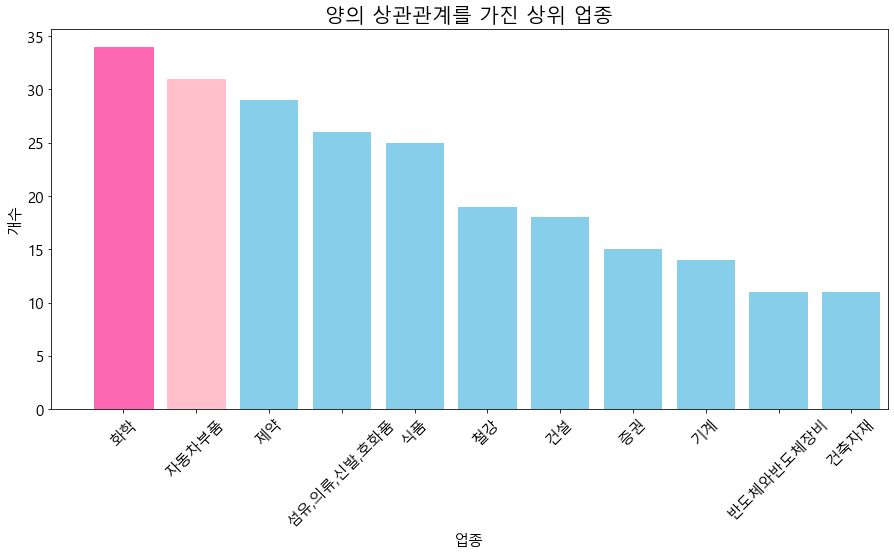

In [ ]:
top_bar_graph(positive,1)

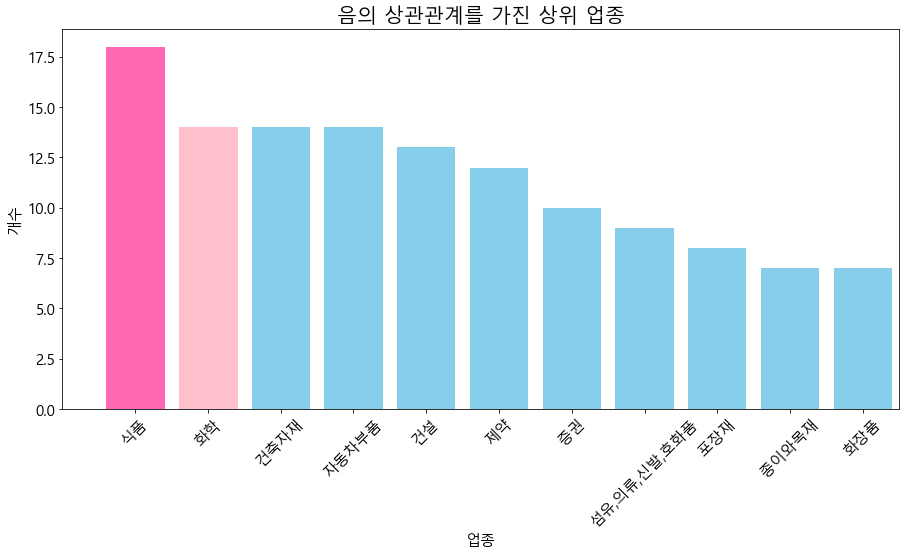

In [ ]:
top_bar_graph(negative,0)

### 4. 5월 27일 쿠팡 물류센터 이후 20일 간

In [ ]:
final_coopang=pd.merge(left=result_coopang, right=stock_corona[['회사이름','업종']].drop_duplicates(), on='회사이름') # stock data와 병합

final_coopang=final_coopang[final_coopang['업종']!='없종없음']

positive = final_coopang[final_coopang['상관계수'].apply(lambda x: x >= 0.4)]
negative = final_coopang[final_coopang['상관계수'].apply(lambda x: x <= -0.4)]

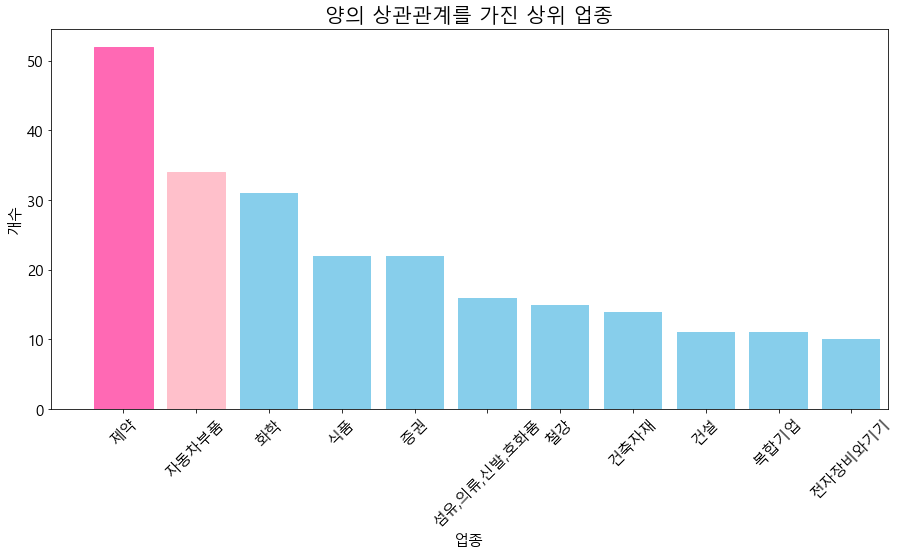

In [ ]:
top_bar_graph(positive,1)

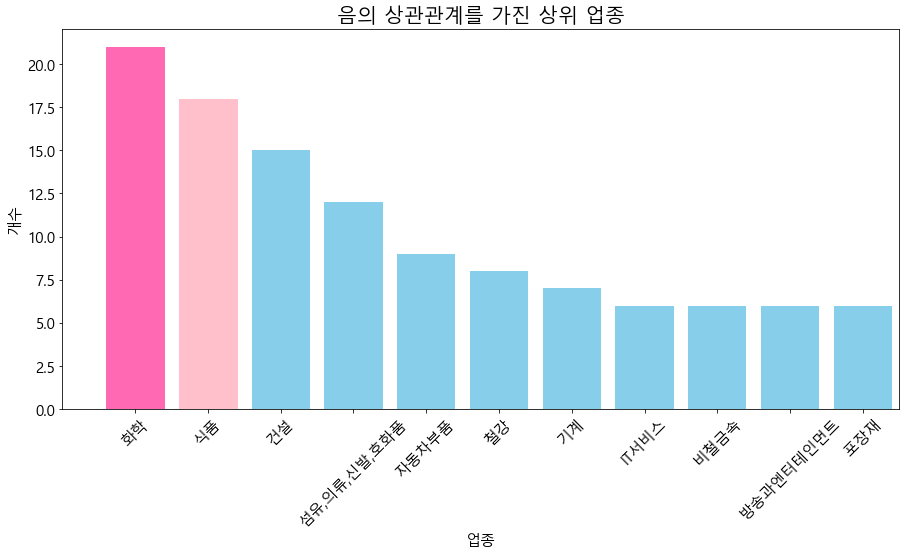

In [ ]:
top_bar_graph(negative,0)

#### 계속해서 양의 상관관계에서 제조업이 2위로 등장하는 이유는 우리나라 산업에서 제조업이 차지하는 비중자체가 크기때문인 것으로 보인다. 양/음 둘다 비교하면 빈도 자체가 음의 상관관계가 높은 회사들이 많다. 

#### 양의 상관관계를 갖는 제조업을 살펴보는 것도 의미가 있어 보인다.

In [ ]:
tmp=result_domain[result_domain['업종']=='섬유,의류,신발,호화품']
tmp=tmp[tmp['상관계수']>=0.4]
tmp

,회사이름,상관계수,업종
48,국동,0.677216,"섬유,의류,신발,호화품"
74,조광피혁,0.576324,"섬유,의류,신발,호화품"
78,비티원,0.564838,"섬유,의류,신발,호화품"
158,경방,0.401105,"섬유,의류,신발,호화품"


 ### <span style='background:yellow'> 위의 회사들은 왜 확진자가 올라감에도 주가가 상승하였는가?

 ### <span style='background:yellow'> 이 제약회사는 왜 주가가 하락하였는가?

In [ ]:
tmp=result_domain[result_domain['업종']=='제약']
tmp=tmp[tmp['상관계수']<=-0.4]
tmp

,회사이름,상관계수,업종
1069,일동홀딩스,-0.407097,제약
1182,한미약품,-0.473553,제약
1431,유한양행우,-0.685395,제약
1436,유한양행,-0.693874,제약
